# Imports

## Librairies

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import time
import logging
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

## Options

In [2]:
sns.set()
warnings.filterwarnings('ignore')

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
pd.set_option('display.max_colwidth', None)

## Data

In [3]:
df = pd.read_csv('../data/cleaned/df.csv', sep=";")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,"202,500.00","406,597.50","24,700.50","351,000.00",...,False,False,False,False,False,True,False,True,False,False
1,100003,0,0,0,0,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",...,True,False,False,False,False,False,False,True,False,False
2,100004,0,1,1,1,0,"67,500.00","135,000.00","6,750.00","135,000.00",...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,0,1,0,"135,000.00","312,682.50","29,686.50","297,000.00",...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,0,1,0,"121,500.00","513,000.00","21,865.50","513,000.00",...,False,False,False,False,False,False,False,False,False,False


# Pipeline

## Préparation des données

In [4]:
if 'TARGET' in df.columns:
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
else:
    X = df.drop(columns=['SK_ID_CURR']).copy()

feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape : {X_train.shape}")
print(f"Test shape : {X_test.shape}")

Train shape : (246008, 242)
Test shape : (61503, 242)


## Construction de la pipeline 

In [5]:
def custom_cost_function(y_true, y_pred, cost_fp, cost_fn):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return cost_fp * fp + cost_fn * fn

In [6]:
cost_scorer = make_scorer(
    custom_cost_function,
    greater_is_better=False,
    cost_fp = 1,
    cost_fn = 10
)

In [7]:
def train_pipeline(X_train, y_train, clf, param_grid, cost_scorer):
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='median')),
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
        ("clf", clf)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=cost_scorer,
        cv=5,
        n_jobs=-1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cost_cv = -grid_search.best_score_
    train_time = end_time - start_time

    train_pipeline_result = pd.DataFrame({
        "Model" : [best_pipeline.named_steps["clf"].__class__.__name__],
        "Hyperparams" : [str(best_params)],
        "Cost_cv" : [best_cost_cv],
        "Train_time" : [train_time]
    })

    return best_pipeline, train_pipeline_result, grid_search

In [8]:
def evaluate_pipeline(pipeline, X_test, y_test, cost_fp=1, cost_fn=10):
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    cost = custom_cost_function(y_test, y_pred, cost_fp=cost_fp, cost_fn=cost_fn)
    cm = confusion_matrix(y_test, y_pred)

    return {
        "accuracy" : accuracy,
        "auc" : auc,
        "cost" : cost,
        "confusion_matrix" : cm
    }

In [9]:
def train_models(X_train, y_train, cost_scorer):
    # Régression Logistique
    param_grid_log = {
        "clf__C" : [0.1, 1, 10]
    }

    best_pipeline_log, df_reg_log, grid_search_log = train_pipeline(
        X_train, y_train, 
        clf=LogisticRegression(class_weight="balanced", max_iter=100, random_state=42),
        param_grid=param_grid_log,
        cost_scorer=cost_scorer
    )

    # RandomForestClassifier
    param_grid_rf = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [2, 5, 10],
        "clf__min_samples_split": [2, 3, 5]
    }
    
    best_pipeline_rf, df_rf, grid_search_rf = train_pipeline(
        X_train, y_train, 
        clf=RandomForestClassifier(class_weight="balanced", random_state=42),
        param_grid=param_grid_rf,
        cost_scorer=cost_scorer
    )

    df_final = pd.concat([df_reg_log, df_rf], ignore_index=True)
    return best_pipeline_log, best_pipeline_rf, df_final, grid_search_log, grid_search_rf

In [10]:
best_pipeline_log, best_pipeline_rf, df_train_results, grid_search_log, grid_search_rf = train_models(
    X_train, y_train, cost_scorer
)

df_train_results

,Model,Hyperparams,Cost_cv,Train_time
0,LogisticRegression,{'clf__C': 10},"27,137.60",83.49
1,RandomForestClassifier,"{'clf__max_depth': 10, 'clf__min_samples_split': 3, 'clf__n_estimators': 100}","28,123.20",404.46


In [11]:
evaluation_log = evaluate_pipeline(best_pipeline_log, X_test, y_test, cost_fp=1, cost_fn=10)
evaluation_rf = evaluate_pipeline(best_pipeline_rf, X_test, y_test, cost_fp=1, cost_fn=10)

In [12]:
df_train_results['Cost_test'] = [evaluation_log['cost'], evaluation_rf['cost']]
df_train_results['Accuracy_test'] = [evaluation_log['accuracy'], evaluation_rf['accuracy']]
df_train_results['AUC_test'] = [evaluation_log['auc'], evaluation_rf['auc']]

df_train_results

,Model,Hyperparams,Cost_cv,Train_time,Cost_test,Accuracy_test,AUC_test
0,LogisticRegression,{'clf__C': 10},"27,137.60",83.49,33668,0.69,0.75
1,RandomForestClassifier,"{'clf__max_depth': 10, 'clf__min_samples_split': 3, 'clf__n_estimators': 100}","28,123.20",404.46,34837,0.72,0.73


In [13]:
best_pipeline_log.feature_names = X_train.columns.tolist()

## Matrice de confusion (meilleur modèle)

In [16]:
y_pred = best_pipeline_log.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[39030 17508]
 [ 1616  3349]]


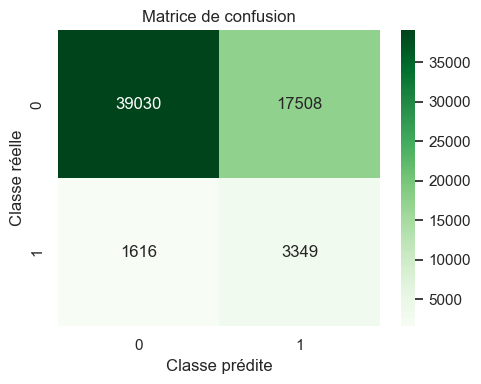

In [17]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

## Sérialisation

In [18]:
def serialization_models(model_log, model_rf, directory="../models"):
    os.makedirs(directory, exist_ok=True)

    model_filename_log = os.path.join(directory, "LogisticRegression_model.joblib")
    model_filename_rf = os.path.join(directory, "RandomForestClassifier_model.joblib")

    joblib.dump(model_log, model_filename_log)
    joblib.dump(model_rf, model_filename_rf)

    print("Les modèles ont été sérialisés et stockés dans le dossier définit.")
    return model_filename_log, model_filename_rf


serialization_models(best_pipeline_log, best_pipeline_rf)

Les modèles ont été sérialisés et stockés dans le dossier définit.


('../models\\LogisticRegression_model.joblib',
 '../models\\RandomForestClassifier_model.joblib')

In [19]:
def save_results(df_results, directory="../results", filename="training_results.csv"):
    os.makedirs(directory, exist_ok=True)
    filepath = os.path.join(directory, filename)
    df_results.to_csv(filepath, index=False, encoding="utf-8")
    print(f"Les résultats des entraîements ont été enregistrés dans {filepath}")


save_results(df_train_results)

Les résultats des entraîements ont été enregistrés dans ../results\training_results.csv
